In [1]:
!pip install casadi
from IPython.display import clear_output
import os

import numpy as np
import casadi
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation

os.makedirs('images',exist_ok=True)
if os.name == 'nt':
    plt.rcParams['font.family'] = 'MS Gothic'
elif os.name == 'posix':
    !pip install japanize-matplotlib


clear_output()

In [41]:
a = 1.750
b = -0.902
c = -0.01

nu = 1 #制御変数の次元
nx = 2 #状態変数の次元

# コスト関数の重み
Q = casadi.diag([1,1])
Q_f = casadi.diag([1,1])
R = casadi.diag([1])

# 予測ホライズン等
K = 10

# 制約条件
x_lb = [-np.inf,-np.inf]
x_ub = [np.inf,np.inf]
u_lb = [-0.2]
u_ub = [0.2]

total = nx*(K+1) + nu*K

x_ref = casadi.DM([1,1])

In [42]:
def make_F():
    states = casadi.SX.sym("states",nx)
    ctrls = casadi.SX.sym("ctrls",nu)

    z_0 = states[0]
    z_1 = states[1]
    u = ctrls[0]

    z_0_next = z_1
    z_1_next = a*z_1 + b*z_0 + c*z_0**3 + u

    states_next = casadi.vertcat(z_0_next,z_1_next)

    F = casadi.Function("F",[states,ctrls],[states_next],['x','u'],['x_next'])
    return F

def compute_stage_cost(x,u):
    x_diff = x - x_ref
    cost = (casadi.dot(Q@x_diff,x_diff) + casadi.dot(R@u,u)) / 2
    return cost

def compute_final_cost(x):
    x_diff = x - x_ref
    cost = casadi.dot(Q_f@x_diff,x_diff) / 2
    return cost

In [43]:
def make_nlp():
    F = make_F()

    U = [casadi.SX.sym(f"u_{i}",nu) for i in range(K)]
    X = [casadi.SX.sym(f"x_{i}",nx) for i in range(K+1)]
    G = []

    J = 0

    for k in range(K):
        J += compute_stage_cost(X[k],U[k])
        eq = X[k+1] - F(x=X[k],u=U[k])["x_next"]
        G.append(eq)
    J += compute_final_cost(X[-1])

    option = {'print_time':False,'ipopt':{'max_iter':10,'print_level':0}}
    nlp = {"x":casadi.vertcat(*X,*U),"f":J,"g":casadi.vertcat(*G)}
    S = casadi.nlpsol("S","ipopt",nlp,option)
    return S

In [44]:
def compute_optimal_control(S,x_init,x0):
    x_init = x_init.full().ravel().tolist()
    
    lbx = x_init + x_lb*K + u_lb*K
    ubx = x_init + x_ub*K + u_ub*K
    lbg = [0]*nx*K
    ubg = [0]*nx*K

    res = S(lbx=lbx,ubx=ubx,lbg=lbg,ubg=ubg,x0=x0)
    
    offset = nx*(K+1)
    x0 = res["x"]
    u_opt = x0[offset:offset+nu]
    return u_opt, x0

In [45]:
S = make_nlp()

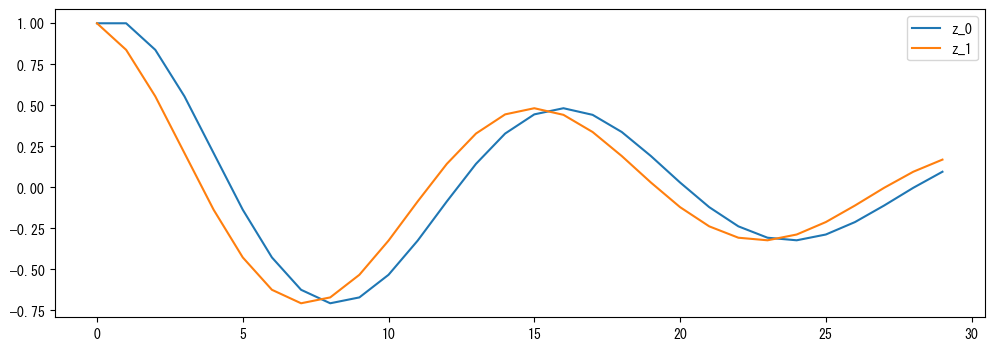

In [47]:
t_span = [0,30]
t_eval = np.arange(*t_span,1)

x_init = casadi.DM([1,1]) # 初期値

F = make_F()

X = [x_init]
x_current = x_init
for t in t_eval:
    x_current = F(x=x_current,u=0)["x_next"]
    X.append(x_current)

X.pop()
X = np.array(X).reshape(t_eval.size,nx)

plt.figure(figsize=(12,4))

plt.subplot(1,1,1)
for k in range(nx):
    plt.plot(t_eval,X[:,k],label=f"z_{k}")
plt.legend()

plt.show()

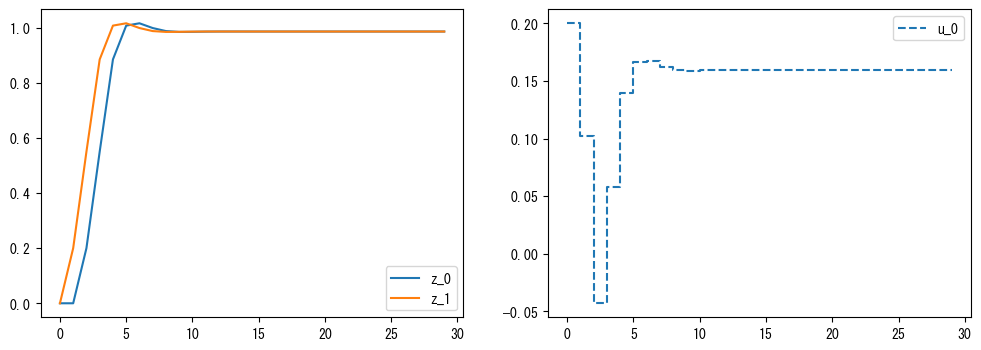

In [46]:
t_span = [0,30]
t_eval = np.arange(*t_span,1)

x_init = casadi.DM([0,0]) # 初期値
x0 = casadi.DM.zeros(total)

F = make_F()

X = [x_init]
U = []
x_current = x_init
for t in t_eval:
    u_opt,x0 = compute_optimal_control(S,x_current,x0)
    x_current = F(x=x_current,u=u_opt)["x_next"]
    X.append(x_current)
    U.append(u_opt)

X.pop()
X = np.array(X).reshape(t_eval.size,nx)
U = np.array(U).reshape(t_eval.size,nu)

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
for k in range(nx):
    plt.plot(t_eval,X[:,k],label=f"z_{k}")
plt.legend()

plt.subplot(1,2,2)
for k in range(nu):
    plt.step(t_eval,U[:,k],linestyle="--",label=f"u_{k}")
plt.legend()

plt.show()

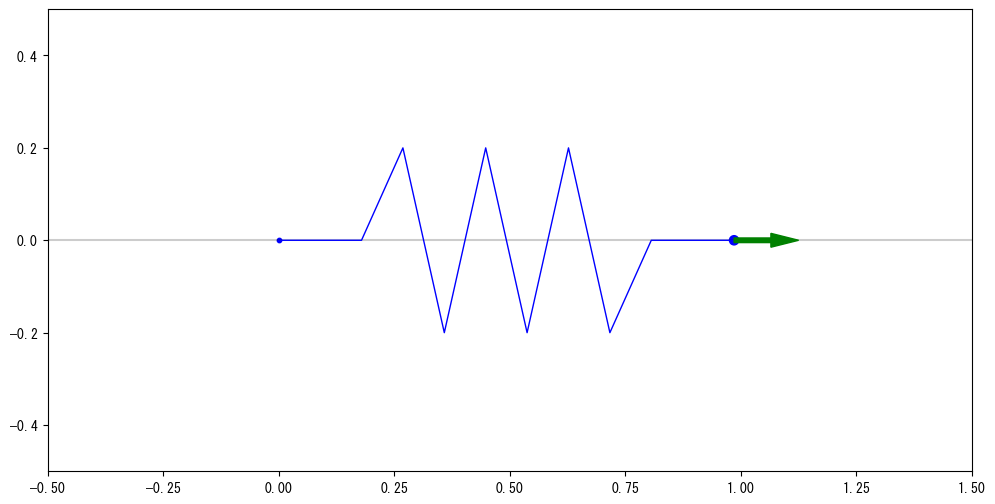

In [10]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
frames = np.arange(0,t_eval.size)
fps = 5

def update_figure(i):
    x_lim_min = -0.5
    x_lim_max = 1.5
    y_lim_min = -0.5
    y_lim_max = 0.5
    u_scale = 2

    ax.cla()
    ax.set_xlim(x_lim_min, x_lim_max)
    ax.set_ylim(y_lim_min, y_lim_max)
    ax.set_aspect("equal")

    z,_ = X[i]
    u, = U[i]

    points = np.array([
        [0,z],
        [0,0]
    ])

    M = 11
    lim = 0.2
    springs = np.array([
        [0,z/M,2*z/M,3*z/M,4*z/M,5*z/M,6*z/M,7*z/M,8*z/M,9*z/M,10*z/M,z],
        [0,0,0,lim,-lim,lim,-lim,lim,-lim,0,0,0]
    ])

    ax.hlines(0,x_lim_min,x_lim_max,colors="black",alpha=0.2)
    ax.scatter(*points,color="blue",s=10)
    ax.plot(*springs, color='blue', lw=1)
    ax.arrow(z,0,u/u_scale,0,width=0.01,head_width=0.03,head_length=0.06,length_includes_head=False,color="green",zorder=3)

    circle = patches.Circle(xy=(z,0), radius=0.01,color="blue")
    ax.add_patch(circle)

ani = FuncAnimation(fig, update_figure, frames=frames)
ani.save("images/chap4_damped oscillation.gif",writer="pillow",fps=fps)

In [ ]:
# import glob
# import natsort
# import cv2
# for i in np.linspace(0,199,12):
#     i = int(i)
#     update_figure(i)
#     fig.savefig(f"./tmp/_frame_{i}.png")
# paths = glob.glob("./tmp/*.png")
# paths = natsort.natsorted(paths)
# paths = [cv2.imread(path) for path in paths]
# paths = np.stack(paths,axis=0)
# paths = paths.reshape(4,3,600,1200,3)
# paths = np.concatenate(paths,axis=1)
# paths = np.concatenate(paths,axis=1)
# # paths = cv2.resize(paths,dsize=None,fx=1/3,fy=1/3)
# cv2.imwrite("images/chap5_cart_pole_anim.png",paths)

True